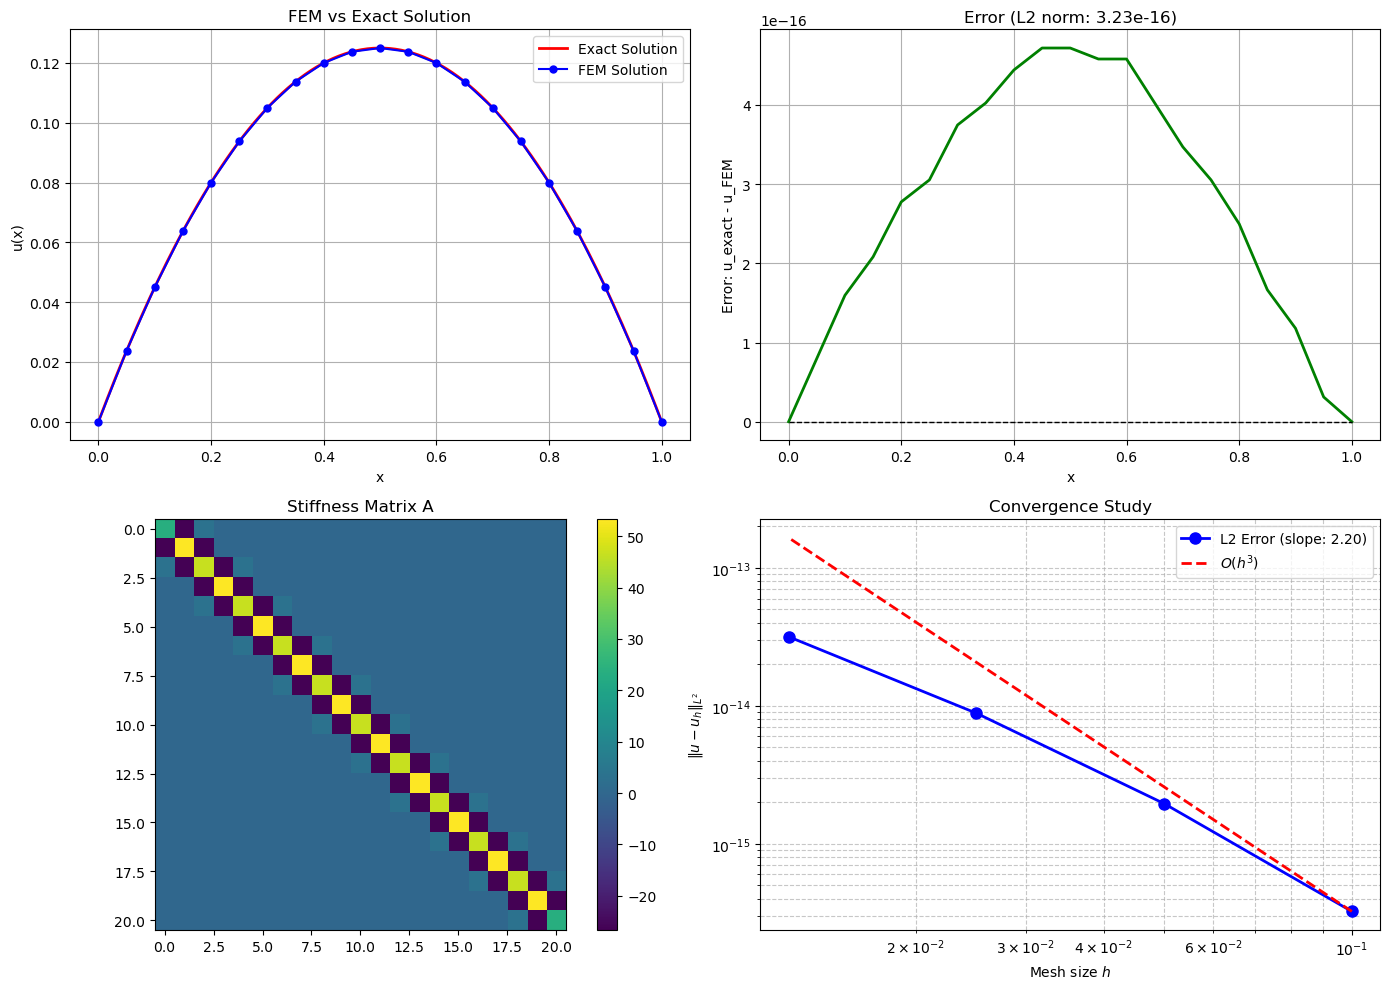

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class FEMPoissonSolver:
    def __init__(self, M, f, exact):
        # M: number of elements; f: forcing function; exact: exact solution (for error computation)
        self.M = M
        self.f = f
        self.exact = exact
        self.h = 1.0 / M
        self.N = 2 * M + 1  # quadratic elements: 2*M+1 nodes on [0,1]
        self.nodes = np.linspace(0, 1, self.N)
        # Precomputed reference stiffness matrix integrals (analytically derived)
        self.I_ref = np.array([[7/3, -8/3,  1/3],
                               [-8/3, 16/3, -8/3],
                               [ 1/3, -8/3,  7/3]])
        # Simpson quadrature on [0,1] for local load integrals
        self.xi_quad = np.array([0.0, 0.5, 1.0])
        self.w_quad  = np.array([1/6, 4/6, 1/6])
        self.A = np.zeros((self.N, self.N))
        self.F = np.zeros(self.N)

    @staticmethod
    def phi(i, xi):
        # Quadratic Lagrange basis on reference element with nodes 0, 0.5, 1.
        if i == 0:
            return 2 * (xi - 0.5) * (xi - 1)
        elif i == 1:
            return -4 * xi * (xi - 1)
        elif i == 2:
            return 2 * xi * (xi - 0.5)

    def assemble(self):
        # Loop over elements; global indices for element k are [2*k, 2*k+1, 2*k+2]
        for k in range(self.M):
            indices = np.array([2*k, 2*k+1, 2*k+2])
            h_k = self.nodes[indices[-1]] - self.nodes[indices[0]]  # equals self.h for uniform mesh
            A_loc = (1 / h_k) * self.I_ref  # local stiffness matrix
            b_loc = np.zeros(3)
            x_left = self.nodes[indices[0]]
            # Compute local load vector using Simpson’s rule
            for q, xi in enumerate(self.xi_quad):
                x_q = x_left + h_k * xi
                for i in range(3):
                    b_loc[i] += self.w_quad[q] * self.f(x_q) * self.phi(i, xi)
            b_loc *= h_k
            # Assemble local contributions
            for a in range(3):
                self.A[indices[a], indices] += A_loc[a, :]
                self.F[indices[a]] += b_loc[a]
        # Enforce homogeneous Dirichlet BC: u(0)=0 and u(1)=0.
        free = np.arange(1, self.N - 1)
        self.free = free
        self.A_reduced = self.A[np.ix_(free, free)]
        self.F_reduced = self.F[free]

    def solve(self):
        self.u_free = np.linalg.solve(self.A_reduced, self.F_reduced)
        self.u = np.zeros(self.N)
        self.u[self.free] = self.u_free
        return self.u

    def L2_error(self):
        delta = self.h / 2
        error_sq = 0
        for i in range(self.N):
            err = self.exact(self.nodes[i]) - self.u[i]
            weight = 0.5 if (i == 0 or i == self.N - 1) else 1.0
            error_sq += weight * err**2
        return np.sqrt(delta * error_sq)
    
    def plot(self, fine_mesh=200):
        """
        Create helpful visualization plots for the FEM solution
        
        Parameters:
        -----------
        fine_mesh : int
            Number of points to use for a finer mesh when plotting exact solution
        """
        # Create a figure with multiple subplots
        fig, axs = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot 1: FEM solution vs exact solution
        x_fine = np.linspace(0, 1, fine_mesh)
        u_exact = np.array([self.exact(x) for x in x_fine])
        
        axs[0, 0].plot(x_fine, u_exact, 'r-', linewidth=2, label='Exact Solution')
        axs[0, 0].plot(self.nodes, self.u, 'bo-', markersize=5, label='FEM Solution')
        axs[0, 0].set_title('FEM vs Exact Solution')
        axs[0, 0].set_xlabel('x')
        axs[0, 0].set_ylabel('u(x)')
        axs[0, 0].legend()
        axs[0, 0].grid(True)
        
        # Plot 2: Error plot
        error = np.array([self.exact(x) - self.u[i] for i, x in enumerate(self.nodes)])
        axs[0, 1].plot(self.nodes, error, 'g-', linewidth=2)
        axs[0, 1].plot(self.nodes, np.zeros_like(self.nodes), 'k--', linewidth=1)
        axs[0, 1].set_title(f'Error (L2 norm: {self.L2_error():.2e})')
        axs[0, 1].set_xlabel('x')
        axs[0, 1].set_ylabel('Error: u_exact - u_FEM')
        axs[0, 1].grid(True)
        
        # Plot 3: Stiffness matrix visualization
        im = axs[1, 0].imshow(self.A, cmap='viridis')
        axs[1, 0].set_title('Stiffness Matrix A')
        plt.colorbar(im, ax=axs[1, 0])
        
        # Plot 4: Convergence study for different mesh sizes
        M_vals = [10, 20, 40, 80]
        errors = []
        hs = []
        
        # Store current M to avoid recomputation
        current_M = self.M
        current_u = self.u.copy()
        
        for M in M_vals:
            temp_solver = FEMPoissonSolver(M, self.f, self.exact)
            temp_solver.assemble()
            temp_solver.solve()
            errors.append(temp_solver.L2_error())
            hs.append(1.0/M)
        
        hs = np.array(hs)
        errors = np.array(errors)
        p = np.polyfit(np.log(hs), np.log(errors), 1)[0]
        
        axs[1, 1].loglog(hs, errors, 'bo-', linewidth=2, markersize=8, 
                         label=f'L2 Error (slope: {abs(p):.2f})')
        axs[1, 1].loglog(hs, errors[0]*(hs[0]/hs)**3, 'r--', linewidth=2, label='$O(h^3)$')
        axs[1, 1].set_xlabel('Mesh size $h$')
        axs[1, 1].set_ylabel('$\\|u - u_h\\|_{L^2}$')
        axs[1, 1].grid(True, which='both', ls='--', alpha=0.7)
        axs[1, 1].legend()
        axs[1, 1].set_title('Convergence Study')
        
        plt.tight_layout()
        plt.show()


# Example usage:
M = 10
f = lambda x: 1.0
exact = lambda x: 0.5 * x * (1 - x)
solver = FEMPoissonSolver(M, f, exact)
solver.assemble()
solver.solve()
solver.plot(fine_mesh=200)
